# MPOW Data Analysis

## Imports

In [1]:
import numpy
import os
import pandas
import plotnine as gg2
import statsmodels.api as sm
import sys
from mpow import load_data, plotting, regression
plotting.output_notebook(hide_banner=True)

## Config

In [2]:
source = load_data.Sources.ProtocolFinal

## Load data

In [3]:
data = load_data.norm_daily_data(source=source)
intraday = load_data.norm_intraday_data(source=source)
details = load_data.norm_detail_data(source=source).dropna()

## Explore details

### Age

Overall Distribution

In [4]:
plotting.show(plotting.histogram(details.AgeAtAdmit, bins=15))

Conditional on gender

In [5]:
details[['Gender', 'AgeAtAdmit']].groupby('Gender').median()

,AgeAtAdmit
Gender,
female,68
male,67


Conditional on depression

In [6]:
pandas.concat([
    details[details.Gender=='male'].AgeAtAdmit.describe().to_frame('MaleAgeStats'),
    details[details.Gender=='female'].AgeAtAdmit.describe().to_frame('FemaleAgeStats')
], axis=1)

,MaleAgeStats,FemaleAgeStats
count,36.000000,59.000000
mean,64.166667,66.627119
std,17.334524,12.363598
min,1.000000,20.000000
25%,56.750000,64.000000
50%,67.000000,68.000000
75%,75.250000,75.000000
max,92.000000,83.000000


In [7]:
details[['Gender', 'AgeAtAdmit', 'Depression']].groupby('Depression').median()

,AgeAtAdmit
Depression,
0.0,68
1.0,68


Conditional on impairment

In [8]:
details[['ImpairmentGroup', 'AgeAtAdmit']].groupby('ImpairmentGroup').median().sort_values('AgeAtAdmit')

,AgeAtAdmit
ImpairmentGroup,
Stroke,51.0
Amputations,56.0
Brain_Dysfunction,60.0
Debility,61.0
Spinal_Cord_Dysfunction,67.5
Major_Multiple_Trauma,70.0
Orthopaedic_Disorders,72.0
Neurologic_conditions,75.0
Cardiac,80.0


### Impairment

In [9]:
details.ImpairmentGroup.value_counts()

Spinal_Cord_Dysfunction    36
Orthopaedic_Disorders      30
Debility                    9
Brain_Dysfunction           6
Amputations                 5
Stroke                      3
Neurologic_conditions       3
Cardiac                     2
Major_Multiple_Trauma       1
Name: ImpairmentGroup, dtype: int64

## Depression Gender Interaction

### Model

Model: $$\LARGE{s_{t,i} \sim \beta_{0} + \beta_{1}p_{t,i} + \alpha^{df} + \alpha^{nf} + \alpha^{dm} + \alpha^{nm} + \epsilon_{t,i}}$$

### Computation

In [10]:
dgi = data.copy()
dgi['FemDep'] = ((dgi.Depression==1)&(dgi.Gender=='female')).astype(int)
dgi['MaleDep'] = ((dgi.Depression==1)&(dgi.Gender=='male')).astype(int)
dgi['FemNon'] = ((dgi.Depression==0)&(dgi.Gender=='female')).astype(int)
dgi['MaleNon'] = ((dgi.Depression==0)&(dgi.Gender=='male')).astype(int)

In [11]:
dgi_cats = {2:'FemNon',3:'MaleNon',4:'FemDep',6:'MaleDep'}
dgi_counts = (((details.Depression + 1) * ((details.Gender=='male').astype(int) + 2))
              .to_frame('DepGenInter').applymap(dgi_cats.get))
dgi_counts.DepGenInter.value_counts()

FemNon     36
MaleNon    27
FemDep     23
MaleDep     9
Name: DepGenInter, dtype: int64

In [12]:
dgi['SexDepressionCategory'] = ((1*dgi['FemDep'] + 
                                 2*dgi['MaleDep'] + 
                                 3*dgi['FemNon'] + 
                                 4*dgi['MaleNon'])
                                .apply({1:'Female Depressed    ',
                                        2:'Male Depressed    ',
                                        3:'Female Non-Depressed   ',
                                        4:'Male Non-Depressed   '}.get))

In [13]:
dgi['MPS'] = dgi['PainScore'] / dgi['NumObs']

In [14]:
dgi_model = regression.ols(dgi.dropna(), ['MPS', 'FemDep', 'MaleDep', 'FemNon', 'MaleNon'], 'Intake')
dgi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Intake   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     83.60
Date:                Sat, 02 May 2020   Prob (F-statistic):           2.07e-60
Time:                        18:28:28   Log-Likelihood:                -4260.6
No. Observations:                 908   AIC:                             8531.
Df Residuals:                     903   BIC:                             8555.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3778      1.438      2.349      0.019       0.556       6.200
MPS            8.6210      0.520     16.579      0.000       7.601       9.642
FemDep         8.2740      1.705      4.853      0.000       4.928      11.620
MaleDep       -4.8248      2.408     -2.003      0.045      -9.551      -0.098
FemNon        -2.7312      1.362     -2.005      0.045      -5.404      -0.058
MaleNon        2.6599      1.525      1.744      0.082      -0.334       5.654
==============================================================================
Omnibus:                      511.888   Durbin-Watson:                   0.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5071.393
Skew:                           2.406   Prob(JB):                         0.00
Kurtosis:                      13.531   Cond. No.                     1.92e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.86e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
bse = dict(dgi_model.bse)
for param, coeff in dict(dgi_model.params).items():
    print('{}:\t{:.3f}\t({:.3f}, {:.3f})'.format(param[:5], coeff, coeff - 1.96*bse[param], coeff + 1.96*bse[param]))

const:	3.378	(0.559, 6.196)
MPS:	8.621	(7.602, 9.640)
FemDe:	8.274	(4.932, 11.616)
MaleD:	-4.825	(-9.545, -0.105)
FemNo:	-2.731	(-5.401, -0.061)
MaleN:	2.660	(-0.330, 5.650)


In [16]:
beta0, beta1, femdep, maledep, femnon, malenon = dgi_model.params

In [17]:
def dgi_estimate(p, df, nf, dm, nm):
    return beta0 + beta1*p + femdep*df + femnon*nf + maledep*dm + malenon*nm

In [18]:
ps = numpy.arange(0, 10.1, 0.1)
fit_df = pandas.concat([pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 0, 1, 0), 'DGICategory': len(ps)*['MaleDep']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 0, 0, 1), 'DGICategory': len(ps)*['MaleNon']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 1, 0, 0, 0), 'DGICategory': len(ps)*['FemDep']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 1, 0, 0), 'DGICategory': len(ps)*['FemNon']})], axis=0)

In [19]:
fit_df['DataType'] = 'Fitted'

In [20]:
fit_df.head()

,MPS,Intake,DGICategory,DataType
0,0.0,-1.447000,MaleDep,Fitted
1,0.1,-0.584896,MaleDep,Fitted
2,0.2,0.277207,MaleDep,Fitted
3,0.3,1.139311,MaleDep,Fitted
4,0.4,2.001415,MaleDep,Fitted


In [21]:
dgi.columns

Index(['Patient', 'DayNum', 'Intake', 'PainScore', 'NumObs', 'AgeAtAdmit',
       'Gender', 'ImpairmentGroup', 'Depression', 'FemDep', 'MaleDep',
       'FemNon', 'MaleNon', 'SexDepressionCategory', 'MPS'],
      dtype='object')

In [22]:
dgi[dgi.FemDep==1][['Intake', 'PainScore']].head()

,Intake,PainScore
8,50.0,56.0
9,35.0,32.0
10,20.0,16.0
11,15.0,8.0
12,30.0,14.0


In [23]:
fit_df.head()

,MPS,Intake,DGICategory,DataType
0,0.0,-1.447000,MaleDep,Fitted
1,0.1,-0.584896,MaleDep,Fitted
2,0.2,0.277207,MaleDep,Fitted
3,0.3,1.139311,MaleDep,Fitted
4,0.4,2.001415,MaleDep,Fitted


### Visual

In [24]:
k = 1
fs = 15
fs2 = 10
plot = gg2.ggplot(dgi[dgi.SexDepressionCategory.notnull()]) + \
       gg2.aes(x='MPS', y='Intake', color='SexDepressionCategory') + \
       gg2.geom_point(size=1, alpha=0.4) + \
       gg2.stat_smooth(method='lm', size=1, alpha=0.8) + \
       gg2.labs(x='Pain Score', y='Intake (oMeq)', text_size=fs) + \
       gg2.ggtitle('Opioid Intake vs. Pain Score by Sex and Depression Status [Protocol]') + \
       gg2.theme(**{
            'legend_position':'right', 
            'text':gg2.element_text(size=fs2),
            'plot_title':gg2.element_text(hjust=0.5, size=fs),
            'axis_text':gg2.element_text(size=fs2),
       }) 

/Users/jim/miniconda3/envs/mpow/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


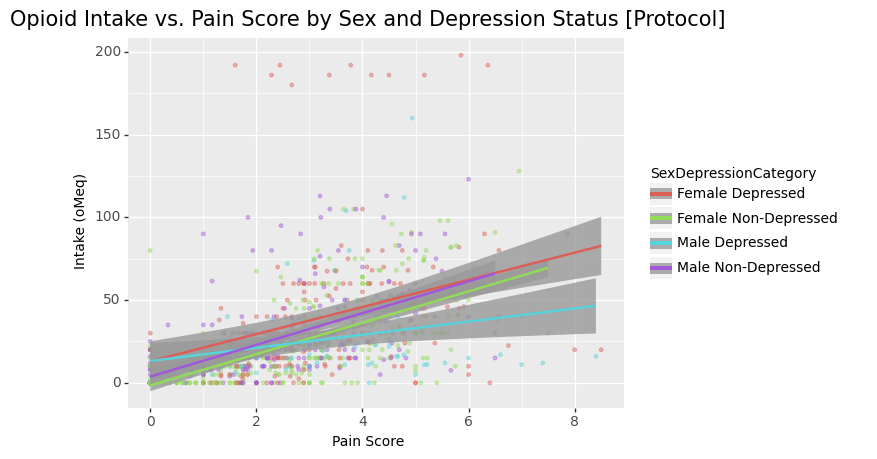

<ggplot: (305655217)>

In [25]:
plot

In [26]:
# plot.save(filename='/Users/jim/repos/collab/collab-mpow/data/img/dep-gen-interaction-proto.png',
#           format='png', height=5, width=8, units='in')

# Comparison of Weaning Rates

Need to first define weaning rate, if we have a time-series of intake $S(t)$, then it's reasonable to consider the time-derivative (modulo some statistical robustness) as the weaning rate, $W(t) \equiv S'(t) = \frac{d}{dt}S(t)$. 

A potential problem with this method is the intraday data do not have time-stamps, so we are reduced to choose a first-difference of daily-aggregate intake, $W(t) \approx S(t) - S(t-\Delta t)$, where $\Delta t = 24hrs$.

Further, not all the time series have the same length since each patient may have a different number of days under care. This makes computing any sort of time-series difference or average more complicated. What we can do, is compute the mean intake vs. time interval, so $\langle W \rangle (t)$, and search for differences between the retrospective $W_R$ and the protocol $W_P$.

In [2]:
data_r = load_data.daily_data(source=load_data.Sources.Retrospective)
data_p = load_data.daily_data(source=load_data.Sources.ProtocolFinal)

In [3]:
data_r['MPS'] = data_r['PainScore'] / data_r['NumObs']
data_p['MPS'] = data_r['PainScore'] / data_r['NumObs']

In [24]:
# Excluding zero-pain reports
data_r = data_r[data_r.MPS!=0]
data_p = data_p[data_p.MPS!=0]

In [13]:
s_r = pandas.concat([data_r.groupby('DayNum')[['Intake']].mean().rename(columns={'Intake': 'MeanIntake'}),
                     data_r.groupby('DayNum')[['MPS']].mean().rename(columns={'MPS': 'MeanMPS'}),
                     data_r.groupby('DayNum')[['Intake']].count().rename(columns={'Intake': 'Count'})], axis=1).reset_index()

s_p = pandas.concat([data_p.groupby('DayNum')[['Intake']].mean().rename(columns={'Intake': 'MeanIntake'}),
                     data_p.groupby('DayNum')[['MPS']].mean().rename(columns={'MPS': 'MeanMPS'}),
                     data_p.groupby('DayNum')[['Intake']].count().rename(columns={'Intake': 'Count'})], axis=1).reset_index()

In [14]:
s_overall = pandas.concat([
    (s_p.melt(id_vars=['DayNum'], value_vars=['MeanIntake', 'MeanMPS', 'Count'], var_name='Stat', value_name='Value')
        .assign(Source='Protocol')),
    (s_r.melt(id_vars=['DayNum'], value_vars=['MeanIntake', 'MeanMPS', 'Count'], var_name='Stat', value_name='Value')
        .assign(Source='Retrospective')),
], axis=0)


### Explore Data Visual

In [27]:
k = 1
fs = 15
fs2 = 10
df = s_overall[(s_overall.Stat=='Count')&(s_overall.DayNum<=21)]
plot = (gg2.ggplot(df) + \
       gg2.aes(x='DayNum', y='Value', color='Source') + \
       gg2.geom_line(size=1, alpha=1) + \
#        gg2.stat_smooth(method='lm', size=1, alpha=0.8) + \
       gg2.labs(x='DayNum', y='Sample Size', text_size=fs) + \
       gg2.ggtitle('Sample Size vs. DayNum by Methodology [Exc 0]') + \
       gg2.theme(**{
            'legend_position':'right', 
            'text':gg2.element_text(size=fs2),
            'plot_title':gg2.element_text(hjust=0.5, size=fs),
            'axis_text':gg2.element_text(size=fs2),
       })) 

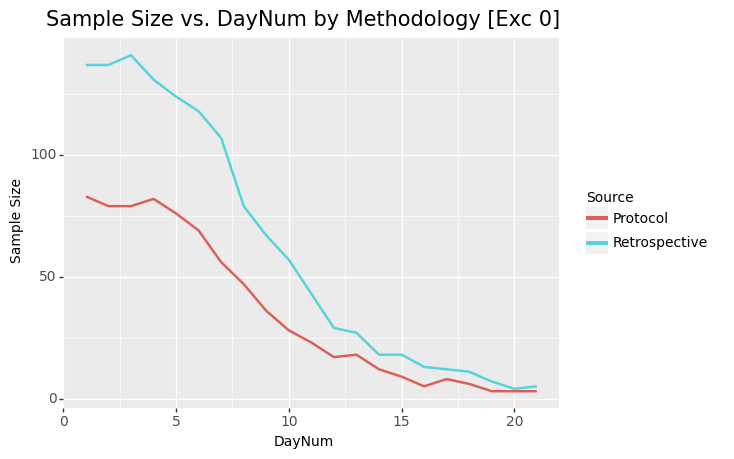

<ggplot: (304862541)>

In [28]:
plot

In [23]:
plot.save(filename='/Users/jim/repos/collab/collab-mpow/data/img/weaning-rates-painscore-ex0.png',
          format='png', height=5, width=8, units='in')

/Users/jim/miniconda3/envs/mpow/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/jim/miniconda3/envs/mpow/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/jim/repos/collab/collab-mpow/data/img/weaning-rates-painscore-ex0.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
